[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/dbwilburn/BIOC6765/blob/main/smFRET_analysis_SP24.ipynb)

## smFRET Analysis from Borgia et al. (2018)
#### DBW 1/24/24


The supplementary data from from Borgia et al. (2018) includes an excel file with all of the smFRET data in Figure 2. Each table in the excel file contains an individual smFRET titration series with dual-labeled Prothymosin-$\alpha$ that should produce a weak FRET signal in the unbound state, and the authors use shift in the population frequency from low to high FRET efficiency to infer the binding constant. The manuscript figure shows the raw smFRET populations for the titration with full-length Histone H1, but neither the salt titration or the H1 fragments. This notebook will plot the raw distributions and infer gaussian distributions for the salt titration data.

Data availability:
https://static-content.springer.com/esm/art%3A10.1038%2Fnature25762/MediaObjects/41586_2018_BFnature25762_MOESM8_ESM.xlsx

In [51]:
# Libraries

import numpy as np, pandas as pd
import scipy.stats as stats
import matplotlib.pyplot as plt

# We will use differential_evolution instead of curve_fit for non-linear curve-fitting as it can be more robust
# in some complex parameter fits, such as Gaussian mixture models
from scipy.optimize import differential_evolution 






Each individual spreadsheet (titration series) is organized with an asymmetric column structure for labeling that is non-trivial foto automatically parse in pandas. Below I include a functions to (1) re-organize the data into a single combined dataframe and (2) perform robust multi-modal gaussian curve fitting using the function `ngauss_search`. You are welcome to reuse this code as part of any homework assignment. Spreadsheets will need to be loaded using the spreadsheet tab #, and I would encourage you to download the excel spreadsheet on your own computer to be able to verify you're looking at the proper spreadsheets using the Python function

In [84]:
# Code to read the data from Borgia et al. and fit gaussian mixture models

unit_to_scaler = {'pM': 1.0, 'nM': 1e3, 'μM':1e6}
param_bounds = [(1e-20, 20), (-2.0, 2.0), (1e-10, 2.0)]

def read_smfret_table(tab_number):
    data_file = 'https://static-content.springer.com/esm/art%3A10.1038%2Fnature25762/MediaObjects/41586_2018_BFnature25762_MOESM8_ESM.xlsx'
    raw_version = pd.read_excel(data_file, sheet_name=tab_number)
    real_columns = [c.rstrip().strip('.1') for c in raw_version.columns if c[:7] != 'Unnamed']
    parts_0 = real_columns[0].split(' ')
    ligand = ' '.join(parts_0[1:-1])
    units = [c.split(' ')[-1][-2:] for c in real_columns]
    #print(real_columns)
    concs = [float(c.strip('.1').split(' ')[-1][:-2]) for c in real_columns]

    skip_version = pd.read_excel(data_file, sheet_name=tab_number, header=1)

    dfs = []
    for j, conc in enumerate(concs):
        focal_data = skip_version.iloc[:,3*j:3*(j+1)].copy()
        focal_data.columns = ['edge','N','width']
        focal_data['FRET_Efficiency'] = focal_data.edge + focal_data.width/2.0
        focal_data['Concentration'] = conc*unit_to_scaler[units[j]]
        focal_data['Ligand'] = ligand
        dfs.append( focal_data[['Ligand','Concentration','FRET_Efficiency','N']])
    data = pd.concat(dfs).reset_index(drop=True)
    return data

def n_gauss(x, *params):
    # params is a 3*n array for n gaussian curves as trios of N/mean/std
    ln_n, mean, std = np.reshape(params, (-1,3)).T # returns three (1,n) arrays
    pred = np.sum(np.exp(ln_n)*stats.norm.pdf(x.reshape((-1,1)), mean, np.clip(std,1e-20,None)), axis=1)
    return pred

def neg_likelihood(params, fret, n, target=0):
    fit = n_gauss(np.array(fret), *params)
    residuals = fit - np.array(n)
    variance = np.mean(residuals**2)
    return np.abs(variance-target)

def ngauss_search(x, y, n, target=0): # strat='best1bin', maxiter=10000, popsize=100, seed=1337):
    bounds = param_bounds*n
    results = differential_evolution(neg_likelihood, bounds, (x,y,target), 'best1bin', maxiter=int(1e4), popsize=20, seed=1337, polish=True)
    return results.x


Examine the first table in the data frame, and compare the results of 1 vs 2 Gaussian curve fits per plot

The <b>Aikaike Information Criterion (AIC)</b> is a common metric for assessing statistical confidence of model fits based on <b>information theory</b>. AIC is very closely related to the <b><i>log-likelihood</i></b> value of a parmeter, with

$AIC = -2 \times (lnL + k)$

with n parameters of value <b>k</b>. The lower the value of AIC, the better the model fit. Every new Gaussian curve increases the parameter space by 3 parameters (p, $\mu$, and $\sigma$).

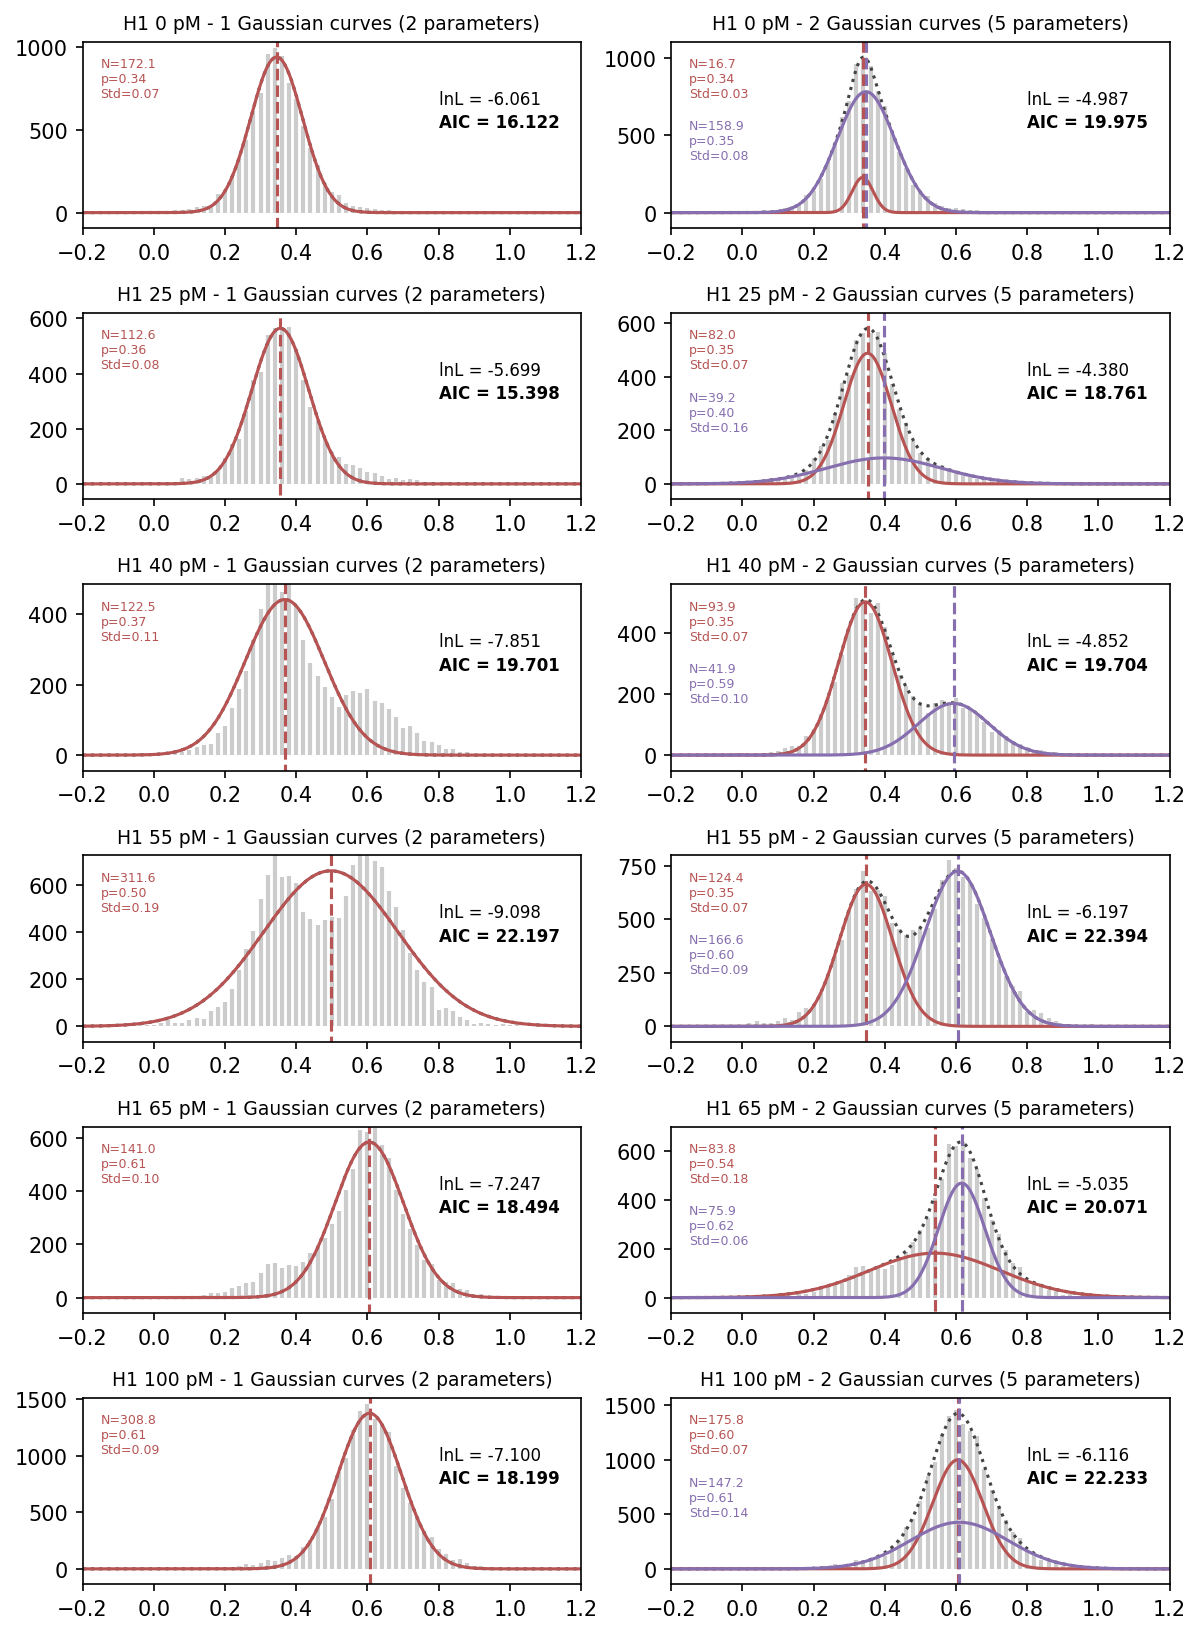

In [110]:
# Plot the first dataframe of values
data = read_smfret_table(0)

line_colors = ['#b75353', '#866eaf']

fig, ax = plt.subplots(figsize=(8,11), dpi=150, nrows=6, ncols=2)
i = 0
for conc, df in data.groupby('Concentration'):
    for j in range(2):
        ligand = list(set(df['Ligand']))[0]
        ax[i,j].vlines(df['FRET_Efficiency'], 0, df['N'], linewidth=2, color='#cccccc')
        fit = ngauss_search(df['FRET_Efficiency'], df['N'], j+1)
        ax[i,j].set_title(ligand+' '+str(int(conc))+' pM - ' + str(j+1) + ' Gaussian curves ('+str(len(fit)-1)+' parameters)', fontsize=9)
        xt = np.linspace(-0.2,1.2,1000)
        yt = n_gauss(xt, *fit)
        ax[i,j].plot(xt, yt, color='#444444', linestyle='dotted')

        lnL = -np.log(neg_likelihood(fit, df['FRET_Efficiency'], df['N']))
        aic = 2*(len(fit)-1-lnL)
        y_max = np.max(yt)
        ax[i,j].text(0.8, y_max*0.7, f'lnL = {lnL:.3f}', fontsize=8)
        ax[i,j].text(0.8, y_max*0.55, f'AIC = {aic:.3f}', fontweight='bold', fontsize=8)

        fit_reshaped = np.reshape(fit, (-1,3))
        fit_reshaped = sorted(fit_reshaped, key=lambda x:x[1]) # sort the parameters based on order of p
        for k, single_fit in enumerate(fit_reshaped):
            single_curve = n_gauss(xt, single_fit)
            ax[i,j].plot(xt, single_curve, color=line_colors[k])
            ax[i,j].plot([single_fit[1]]*2, [-1e3,1e5], linestyle='dashed', color=line_colors[k])
            ax[i,j].text(-0.15, y_max*(1.0-0.4*k), 
                         f'N={np.exp(single_fit[0]):.1f}\np={single_fit[1]:.2f}\nStd={single_fit[2]:.2f}', 
                         fontsize=6, va='top', color=line_colors[k])

        ax[i,j].set(xlim=(-0.2,1.2), ylim=(-0.1*y_max, 1.1*y_max))
    i += 1

fig.tight_layout()


Interestingly, there does not appear to be statistical support for any two parameter fits given the provided data (at least not without extra assumptions, which in this context, is likely a reasonable <i>prior</i>). Following the lead from the authors, we will assume two curve fits for each distribution in the salt titration data

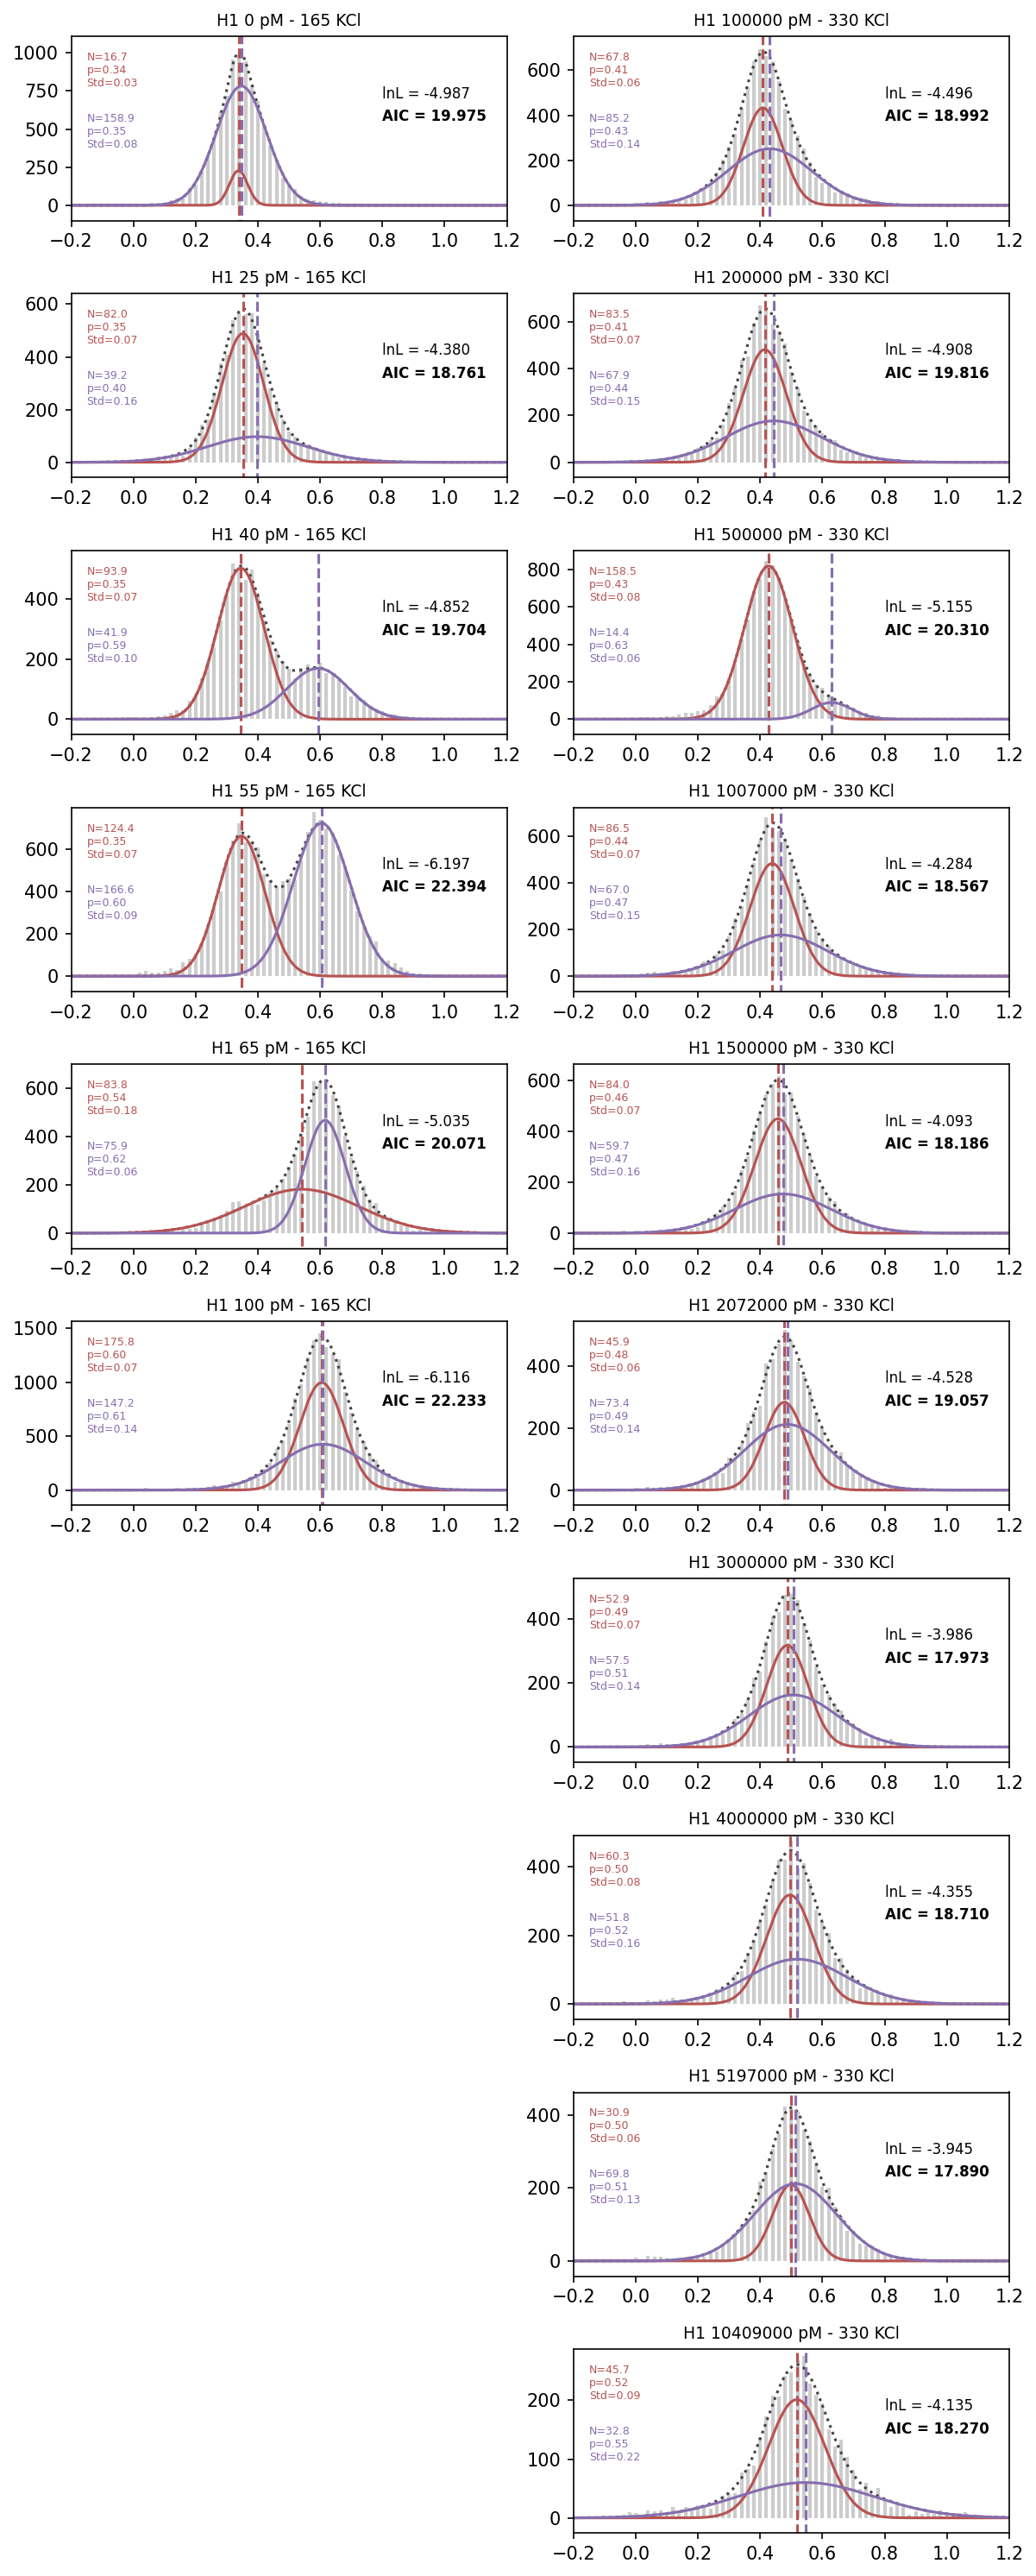

In [116]:
# For the salt titration, we will focus on the 0th and 10th tabs which contain 165 and 330 KCl with full length PA, respectively.

tabs = [0,10]
kcl_concs = [165, 330]
n_rows = 10
n_cols = 2 #2
n_curves = 2
fig, ax = plt.subplots(figsize=(8,20), dpi=150, nrows=n_rows, ncols=n_cols)

# Loop over data and plot
for j, tab in enumerate(tabs):
    #j = k%n_cols # convert tab index to j column
    data = read_smfret_table(tab)
    i = 0
    for conc, df in data.groupby('Concentration'):
        ligand = list(set(df['Ligand']))[0]
        ax[i,j].vlines(df['FRET_Efficiency'], 0, df['N'], linewidth=2, color='#cccccc')
        fit = ngauss_search(df['FRET_Efficiency'], df['N'], n_curves)
        ax[i,j].set_title(ligand+' '+str(int(conc))+' pM - '+str(int(kcl_concs[j]))+' KCl', fontsize=9)
        xt = np.linspace(-0.2,1.2,1000)
        yt = n_gauss(xt, *fit)
        ax[i,j].plot(xt, yt, color='#444444', linestyle='dotted')

        lnL = -np.log(neg_likelihood(fit, df['FRET_Efficiency'], df['N']))
        aic = 2*(len(fit)-1-lnL)
        y_max = np.max(yt)
        ax[i,j].text(0.8, y_max*0.7, f'lnL = {lnL:.3f}', fontsize=8)
        ax[i,j].text(0.8, y_max*0.55, f'AIC = {aic:.3f}', fontweight='bold', fontsize=8)

        fit_reshaped = np.reshape(fit, (-1,3))
        fit_reshaped = sorted(fit_reshaped, key=lambda x:x[1]) # sort the parameters based on order of p
        for k, single_fit in enumerate(fit_reshaped):
            single_curve = n_gauss(xt, single_fit)
            ax[i,j].plot(xt, single_curve, color=line_colors[k])
            ax[i,j].plot([single_fit[1]]*2, [-1e3,1e5], linestyle='dashed', color=line_colors[k])
            ax[i,j].text(-0.15, y_max*(1.0-0.4*k), 
                         f'N={np.exp(single_fit[0]):.1f}\np={single_fit[1]:.2f}\nStd={single_fit[2]:.2f}', 
                         fontsize=6, va='top', color=line_colors[k])

        ax[i,j].set(xlim=(-0.2,1.2), ylim=(-0.1*y_max, 1.1*y_max))
        i+=1

for i in range(6,10):
    ax[i,0].axis('off') # Disable unnecessary axes
        
fig.tight_layout()    
